<img src="data/ner_tags.png">

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn_crfsuite.metrics import flat_classification_report

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print(tags)

data.head(10)

Number of sentences:  47959
Number of words in the dataset:  35178
Number of Labels:  17
['I-nat', 'I-org', 'I-per', 'I-gpe', 'B-org', 'B-nat', 'B-geo', 'I-eve', 'B-tim', 'I-art', 'B-art', 'B-gpe', 'I-geo', 'I-tim', 'O', 'B-per', 'B-eve']


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
class SentenceGetter(object):
    """
    Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]
    """
    
    def __init__(self, data):
        """
        data: pandas.DataFrame which contains the above dataset
        """
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [4]:
getter = SentenceGetter(data)
sentences = getter.sentences

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))

Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O


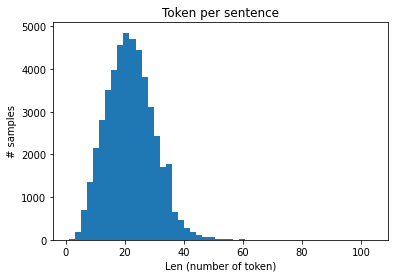

In [5]:
# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [6]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

In [7]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [8]:
# Max length of review (in words)
MAX_LEN = 60

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 60), (4796, 60), (43163, 60, 18), (4796, 60, 18))

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

EPOCHS = 10
BATCH_SIZE = 256
EMBEDDING = 50  # Dimension of word embedding vector

model = Sequential()
model.add(Embedding(input_dim=n_words+2, output_dim=EMBEDDING, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
model.add(CRF(n_tags+1))
model.compile(optimizer="adam", loss=crf_loss, metrics=[crf_accuracy])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 50)            1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 128)           58880     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 50)            6450      
_________________________________________________________________
crf_1 (CRF)                  (None, 60, 18)            1278      
Total params: 1,825,608
Trainable params: 1,825,608
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)
stats = pd.DataFrame(history.history)

/home/sun/miniconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/10
 - 14s - loss: 0.6270 - crf_accuracy: 0.8492 - val_loss: 0.2666 - val_crf_accuracy: 0.9442
Epoch 2/10
 - 13s - loss: 0.1896 - crf_accuracy: 0.9497 - val_loss: 0.1258 - val_crf_accuracy: 0.9624
Epoch 3/10
 - 13s - loss: 0.0997 - crf_accuracy: 0.9724 - val_loss: 0.0814 - val_crf_accuracy: 0.9795
Epoch 4/10
 - 13s - loss: 0.0622 - crf_accuracy: 0.9840 - val_loss: 0.0590 - val_crf_accuracy: 0.9841
Epoch 5/10
 - 13s - loss: 0.0432 - crf_accuracy: 0.9878 - val_loss: 0.0477 - val_crf_accuracy: 0.9860
Epoch 6/10
 - 13s - loss: 0.0334 - crf_accuracy: 0.9896 - val_loss: 0.0425 - val_crf_accuracy: 0.9867
Epoch 7/10
 - 13s - loss: 0.0274 - crf_accuracy: 0.9906 - val_loss: 0.0401 - val_crf_accuracy: 0.9869
Epoch 8/10
 - 13s - loss: 0.0230 - crf_accuracy: 0.9916 - val_loss: 0.0383 - val_crf_accuracy: 0.9872
Epoch 9/10
 - 13s - loss: 0.0194 - crf_accuracy: 0.9922 - val_loss: 0.0383 - val_crf_accuracy: 0.9872
Epoch 10/10
 - 13s - loss: 0.0163

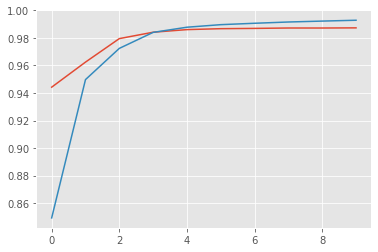

In [11]:
plt.style.use("ggplot")
plt.plot(stats["val_crf_accuracy"])
plt.plot(stats["crf_accuracy"])
plt.show()

In [12]:
# Eval on test data
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [13]:
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/home/sun/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        35
       B-eve       1.00      0.12      0.21        42
       B-geo       0.86      0.87      0.86      3824
       B-gpe       0.94      0.93      0.94      1544
       B-nat       0.00      0.00      0.00        20
       B-org       0.76      0.69      0.72      2032
       B-per       0.84      0.79      0.82      1718
       B-tim       0.90      0.85      0.88      2046
       I-art       0.00      0.00      0.00        33
       I-eve       0.00      0.00      0.00        37
       I-geo       0.81      0.73      0.77       743
       I-gpe       1.00      0.50      0.67        26
       I-nat       0.00      0.00      0.00         5
       I-org       0.81      0.75      0.78      1714
       I-per       0.86      0.81      0.84      1788
       I-tim       0.88      0.68      0.76       681
           O       0.98      0.99      0.99     87652
         PAD       1.00    

In [14]:
def check_sample(ner_model, sample_x, sample_y):
    raw_pred = ner_model.predict(np.array([sample_x]))
    tag_pred = np.argmax(raw_pred, axis=-1)[0]
    ground_truth = np.argmax(sample_y, axis=-1)
    
    print("{:15}{:7}{}".format("WORD", "TRUE", "PRED"))
    for w, t, p in zip(sample_x, ground_truth, tag_pred):
        if w != 0:
            print("{:15}{:7}{}".format(idx2word[w], idx2tag[t], idx2tag[p]))

            
check_sample(model, X[0], y[0])

WORD           TRUE   PRED
Thousands      O      O
of             O      O
demonstrators  O      O
have           O      O
marched        O      O
through        O      O
London         B-geo  B-geo
to             O      O
protest        O      O
the            O      O
war            O      O
in             O      O
Iraq           B-geo  B-geo
and            O      O
demand         O      O
the            O      O
withdrawal     O      O
of             O      O
British        B-gpe  B-gpe
troops         O      O
from           O      O
that           O      O
country        O      O
.              O      O


In [18]:
def predict_sentence(ner_model):
    input_sent = input("Input sentence: ")
    sequence = [word2idx.get(w, 1) for w in word_tokenize(input_sent)]
    processed_sent = pad_sequences(sequences=[sequence],
                                   padding="post", 
                                   value=0, 
                                   maxlen=MAX_LEN)
    
    raw_pred = ner_model.predict(processed_sent)
    tag_pred = np.argmax(raw_pred, axis=-1)[0]
    
    
    print("\n{:15}{}".format("WORD", "PRED"))
    for w, p in zip(sequence, tag_pred):
        if w != 0:
            print("{:15}{}".format(idx2word[w], idx2tag[p]))

predict_sentence(model)

Input sentence: Jim visited Beijing in 2016.

WORD           PRED
Jim            B-per
visited        O
Beijing        B-geo
in             O
2016           B-tim
.              O
